In [210]:
#importing the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7, 8.27)})

In [48]:
#accessing the dataset
country = pd.read_csv("Country-data.csv")

In [49]:
#checking the dataset
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [50]:
#checking the dataset
country.shape

(167, 10)

In [51]:
#all numeric variables. good for PCA
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [52]:
#checking for outliers
country.describe(percentiles=[.25, .5, .75, .90, .99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,70.800000,10.940000,75.420000,41220.000000,16.640000,80.400000,5.322000,41840.000000
99%,153.400000,160.480000,13.474000,146.080000,84374.000000,41.478000,82.370000,6.563600,79088.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [53]:
# Checking the percentage of missing values
round(100*(country.isnull().sum()/len(country.index)), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

#### No missing Data

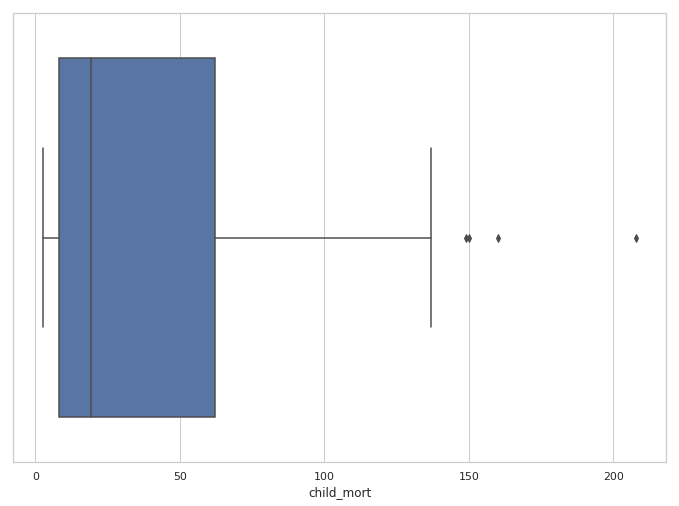

In [211]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=country["child_mort"])

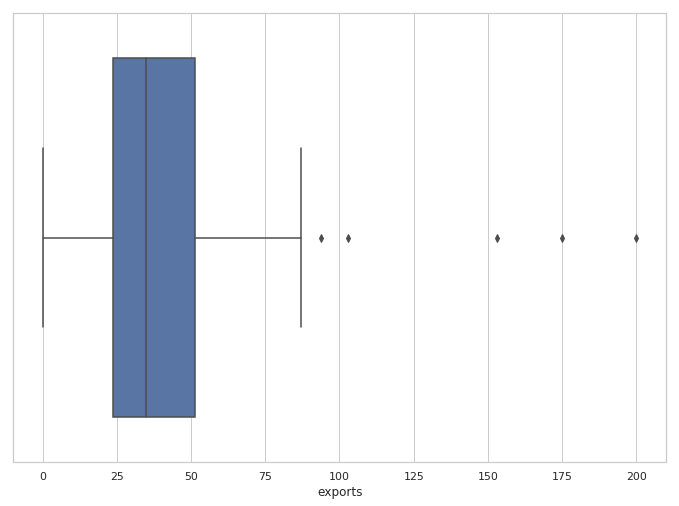

In [212]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=country["exports"])


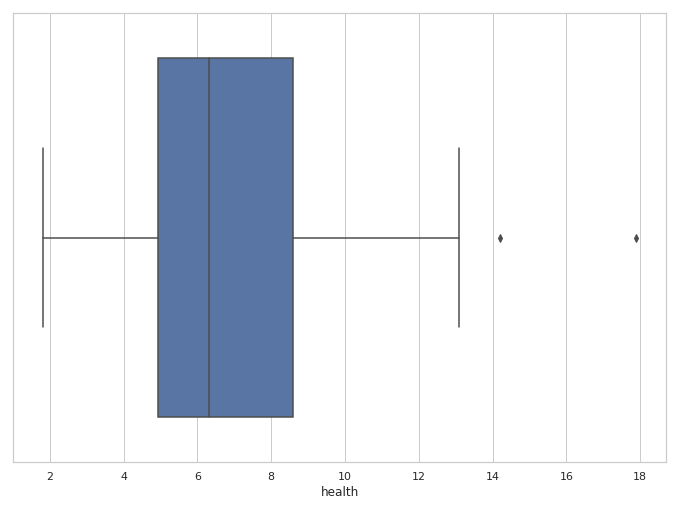

In [213]:
ax = sns.boxplot(x=country["health"])

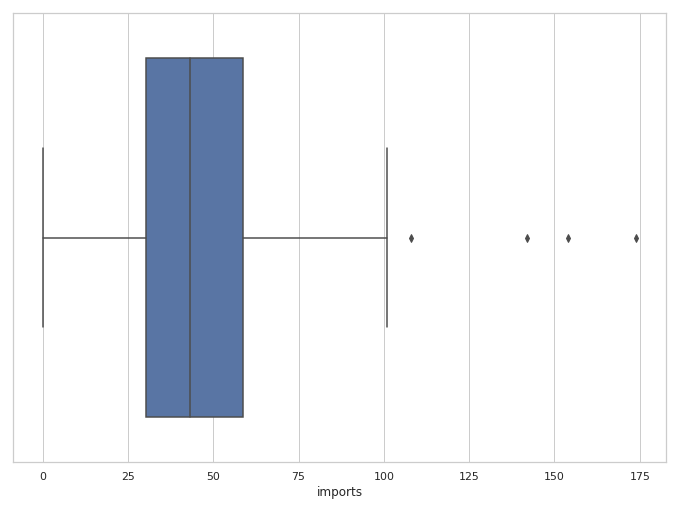

In [214]:
ax = sns.boxplot(x=country["imports"])

In [58]:
#checking the dataset again
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Prepare the data for modelling

##### R (Recency): The average number of years a new born child would live if the current mortality patterns are to remain the same
##### F (Frequency): Death of children under 5 years of age per 1000 live births
##### M (Monetary): The GDP per capita. Calculated as the Total GDP divided by the total population.

In [61]:
frequency = country.groupby('country')['child_mort'].sum()
frequency = frequency.reset_index()
frequency.columns = ['country', 'mortality']
frequency.head()

,country,mortality
0,Afghanistan,90.2
1,Albania,16.6
2,Algeria,27.3
3,Angola,119.0
4,Antigua and Barbuda,10.3


In [62]:
# merge the two dfs
grouped_df = pd.merge(monetary, frequency, on='country', how='inner')
grouped_df.head()

,country,gdpp,mortality
0,Afghanistan,553,90.2
1,Albania,4090,16.6
2,Algeria,4460,27.3
3,Angola,3530,119.0
4,Antigua and Barbuda,12200,10.3


In [63]:
#frequency

recency = country.groupby('country')['life_expec'].sum()
recency = recency.reset_index()
recency.columns = ['country', 'life_expec']
recency.head()

,country,life_expec
0,Afghanistan,56.2
1,Albania,76.3
2,Algeria,76.5
3,Angola,60.1
4,Antigua and Barbuda,76.8


In [64]:
# merge
grouped_df = pd.merge(monetary, frequency, on='country', how='inner')
grouped_df.head()
grouped_df = pd.merge(grouped_df, recency, on='country', how='inner')

In [65]:
grouped_df.head()

,country,gdpp,mortality,life_expec
0,Afghanistan,553,90.2,56.2
1,Albania,4090,16.6,76.3
2,Algeria,4460,27.3,76.5
3,Angola,3530,119.0,60.1
4,Antigua and Barbuda,12200,10.3,76.8


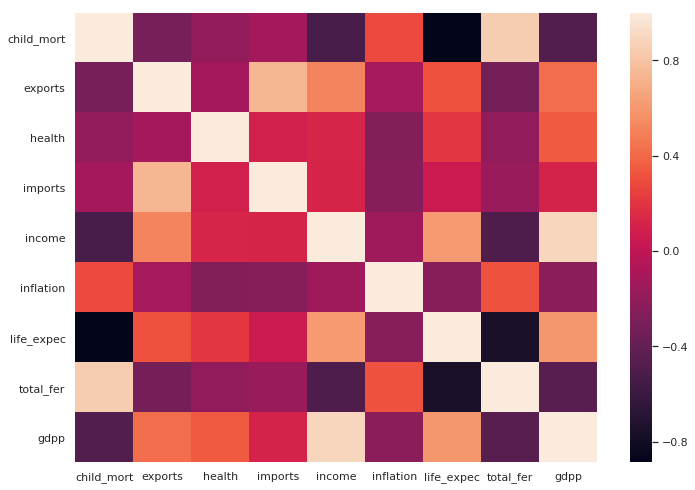

In [215]:
# just to check where things originally stand
corr = country.corr()
sns.heatmap(corr)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1a53cd68>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1a545780>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1a53cbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1a545e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1a545f98>],
 'means': []}

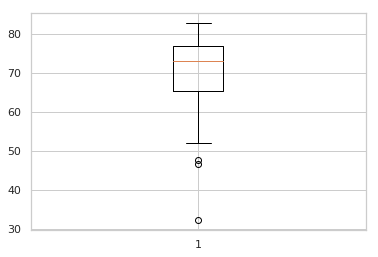

In [66]:
# 1. outlier treatment
plt.boxplot(grouped_df['life_expec'])

In [67]:
# removing (statistical) outliers
Q1 = grouped_df.gdpp.quantile(0.05)
Q3 = grouped_df.gdpp.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.gdpp >= Q1 - 1.5*IQR) & (grouped_df.gdpp <= Q3 + 1.5*IQR)]


In [68]:

# outlier treatment for recency
Q1 = grouped_df.life_expec.quantile(0.05)
Q3 = grouped_df.life_expec.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.life_expec >= Q1 - 1.5*IQR) & (grouped_df.life_expec <= Q3 + 1.5*IQR)]



In [69]:
grouped_df.head()

,country,gdpp,mortality,life_expec
0,Afghanistan,553,90.2,56.2
1,Albania,4090,16.6,76.3
2,Algeria,4460,27.3,76.5
3,Angola,3530,119.0,60.1
4,Antigua and Barbuda,12200,10.3,76.8


In [70]:
# outlier treatment for frequency
Q3 = grouped_df.mortality.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.mortality >= Q1 - 1.5*IQR) & (grouped_df.mortality <= Q3 + 1.5*IQR)]

In [71]:
# 2. rescaling
rfm_df = grouped_df[['gdpp', 'mortality', 'life_expec']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(166, 3)

Great! we have reduced from 10 dimensions to just 3

In [72]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['gdpp', 'mortality', 'life_expec']
rfm_df_scaled.head()

,gdpp,mortality,life_expec
0,-0.682118,1.389720,-1.741953
1,-0.488878,-0.541890,0.658295
2,-0.468664,-0.261072,0.682178
3,-0.519473,2.145567,-1.276233
4,-0.045798,-0.707231,0.718002


Text(0, 0.5, 'Second  Component')

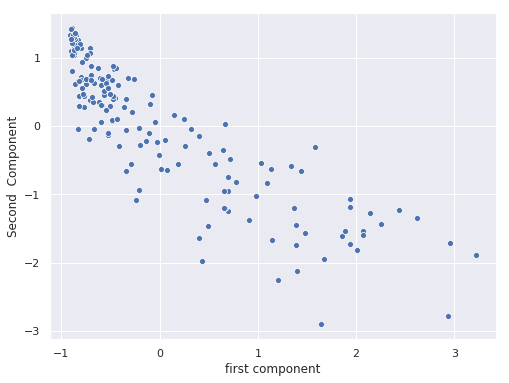

In [223]:
# did this out of curiocity as how it looks before clustering
import seaborn as sns; sns.set()
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="mortality", y="life_expec", data=rfm_df_scaled, cmap='plasma')
plt.xlabel('first component')
plt.ylabel('Second  Component')

## 3 Modeling

In [73]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 2, 1, 0, 1, 3, 1, 3,
       1, 2, 1, 0, 0, 3, 0, 2, 1, 0, 0, 1, 1, 1, 3, 0, 3, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 3, 1, 3, 2, 2, 3, 3, 1, 2, 3, 2, 1, 1, 0, 0, 3,
       1, 2, 3, 1, 1, 3, 2, 2, 2, 1, 2, 1, 1, 3, 3, 2, 3, 3, 1, 1, 0, 0,
       1, 1, 2, 1, 3, 0, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 3, 3, 2,
       2, 0, 0, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 0,
       2, 1, 1, 3, 3, 1, 2, 1, 1, 3, 1, 2, 2, 3, 3, 1, 3, 0, 1, 1, 1, 3,
       0, 1, 2, 2, 2, 1, 3, 3, 1, 1, 3, 0], dtype=int32)

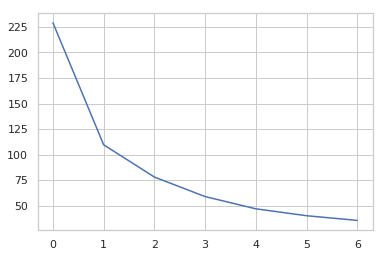

In [75]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [76]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5036690445114214
For n_clusters=3, the silhouette score is 0.5513159815339969
For n_clusters=4, the silhouette score is 0.49655412160455736
For n_clusters=5, the silhouette score is 0.4977206405260229
For n_clusters=6, the silhouette score is 0.4284679095718458
For n_clusters=7, the silhouette score is 0.3934001373030597
For n_clusters=8, the silhouette score is 0.37481257796496054


In [81]:
# final model with k=2
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [82]:
kmeans.labels_

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1,
       0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2,
       2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [110]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,country,gdpp,mortality,life_expec,cluster_id,cluster_labels
0,Afghanistan,553,90.2,56.2,1,0
1,Albania,4090,16.6,76.3,0,1
2,Algeria,4460,27.3,76.5,0,1
3,Angola,3530,119.0,60.1,1,0
4,Antigua and Barbuda,12200,10.3,76.8,0,1


In [111]:
grouped_df.tail()

,country,gdpp,mortality,life_expec,cluster_id,cluster_labels
162,Vanuatu,2970,29.2,63.0,0,1
163,Venezuela,13500,17.1,75.4,0,1
164,Vietnam,1310,23.3,73.1,0,1
165,Yemen,1310,56.3,67.5,0,1
166,Zambia,1460,83.1,52.0,1,0


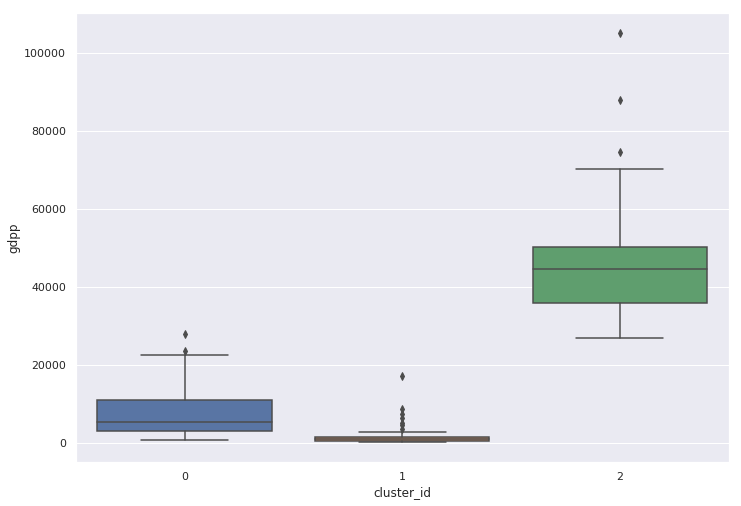

In [217]:
# plot
sns.boxplot(x='cluster_id', y='gdpp', data=grouped_df)

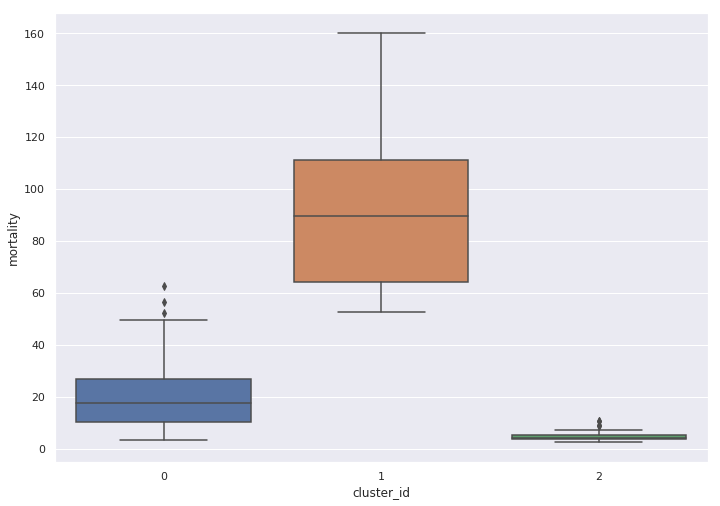

In [224]:
# plot
sns.boxplot(x='cluster_id', y='mortality', data=grouped_df)

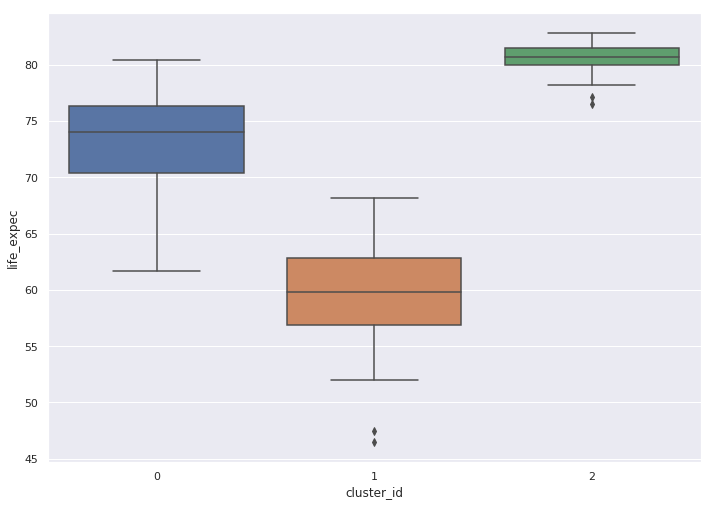

In [225]:
# plot
sns.boxplot(x='cluster_id', y='life_expec', data=grouped_df)

### Hierarchical Clustering

In [113]:
rfm_df_scaled.head()

,gdpp,mortality,life_expec
0,-0.682118,1.389720,-1.741953
1,-0.488878,-0.541890,0.658295
2,-0.468664,-0.261072,0.682178
3,-0.519473,2.145567,-1.276233
4,-0.045798,-0.707231,0.718002


In [114]:
grouped_df.head()

,country,gdpp,mortality,life_expec,cluster_id,cluster_labels
0,Afghanistan,553,90.2,56.2,1,0
1,Albania,4090,16.6,76.3,0,1
2,Algeria,4460,27.3,76.5,0,1
3,Angola,3530,119.0,60.1,1,0
4,Antigua and Barbuda,12200,10.3,76.8,0,1


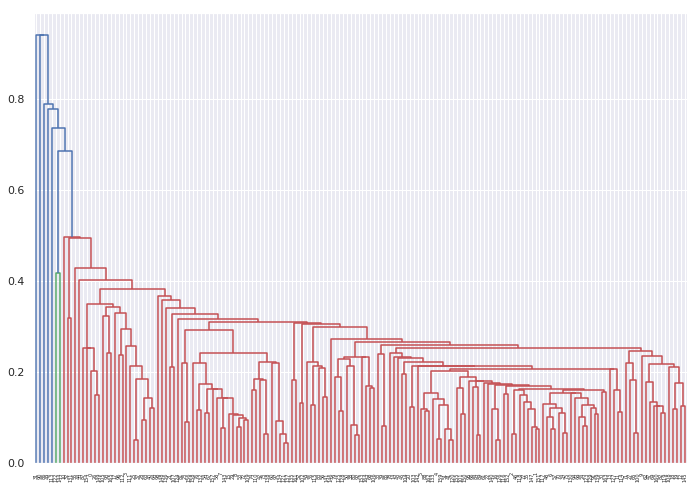

In [218]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

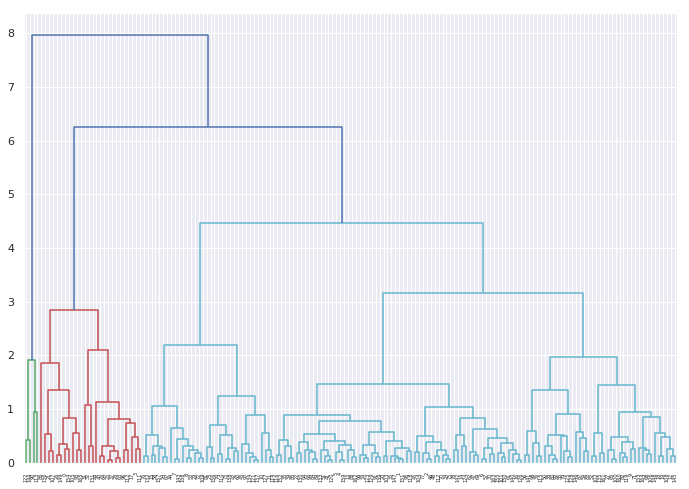

In [219]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [117]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [118]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,country,gdpp,mortality,life_expec,cluster_id,cluster_labels
0,Afghanistan,553,90.2,56.2,1,0
1,Albania,4090,16.6,76.3,0,1
2,Algeria,4460,27.3,76.5,0,1
3,Angola,3530,119.0,60.1,1,0
4,Antigua and Barbuda,12200,10.3,76.8,0,1


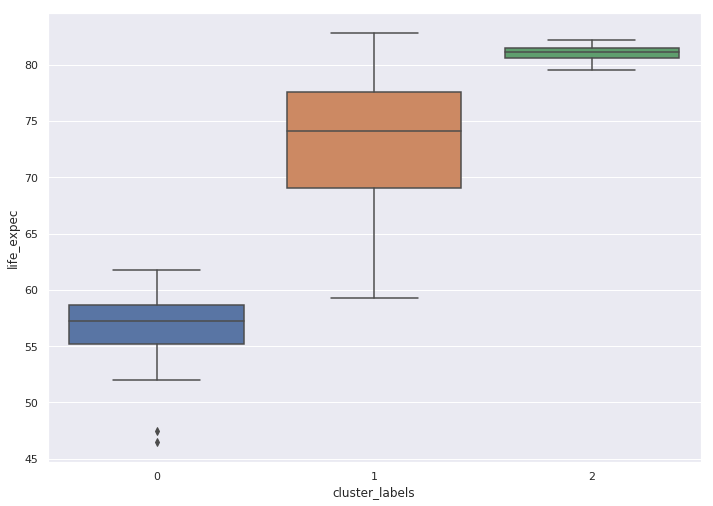

In [227]:
# plot that confirms that with 3 clusters the model is optimal
sns.boxplot(x='cluster_labels', y='life_expec', data=grouped_df)

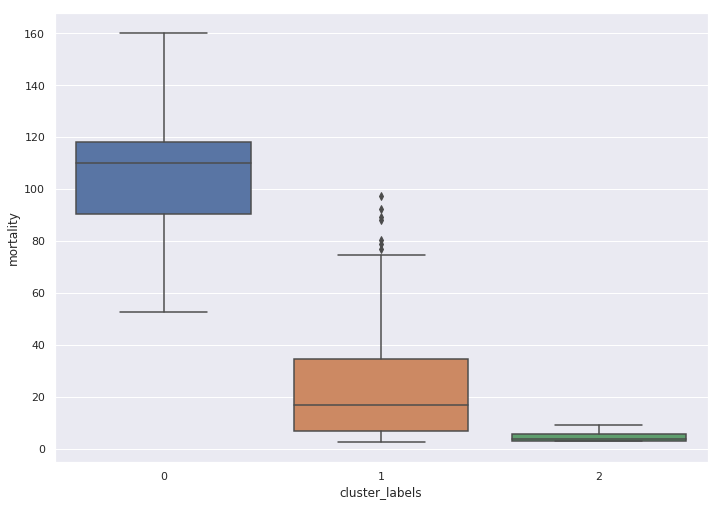

In [221]:
# plots
sns.boxplot(x='cluster_labels', y='mortality', data=grouped_df)

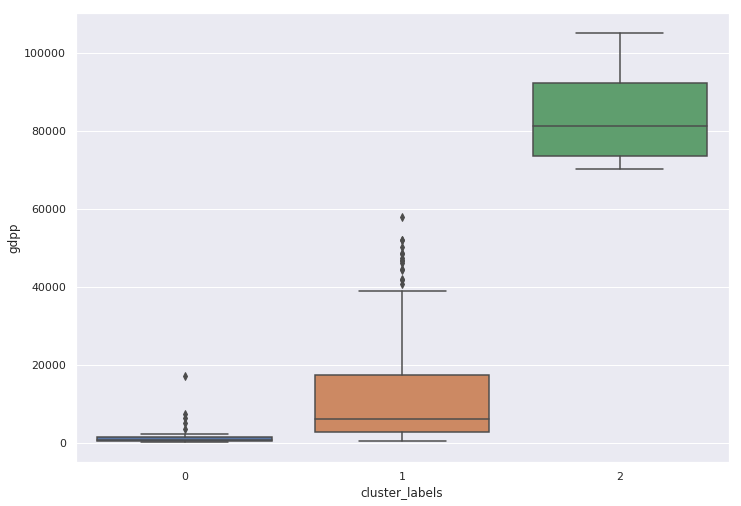

In [222]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=grouped_df)

In [122]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [123]:
#Applying PCA on the dataset
pca.fit(rfm_df_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [124]:
#Let's check the components
pca.components_

array([[ 0.5081849 , -0.59437697,  0.62326891],
       [ 0.84562905,  0.48155304, -0.23025676],
       [ 0.16327772, -0.6440673 , -0.74734041]])

### Property 1: Principal Components are weighted linear combinations of Original Variables

In [125]:
#The original variables are the original axes here given by X(1,0,0), Y(0,1,0) and Z(0,0,1)
#We need to show that PCs that are formed are the linear combinations of X,Y and Z.
lincom  = pca.components_[0]
setvec = np.array([[1,0,0],[0,1,0],[0,0,1]])
x,y,z = np.linalg.solve(setvec, lincom)
round(x,2),round(y,2),round(z,2)

(0.51, -0.59, 0.62)

Hence it is verfied that these PCs are linear combinations of the original variables

### Property 2: Principal Components are perpendicular to each other


In [126]:
#For verifying this we would be calculating the dot product of any of the two PCs.
#We know that dot product of any 2 perpendicular vectors is 0.
round(np.dot(pca.components_[0],pca.components_[1]))

-0.0

### Property 3: Principal Components capture maximum variance and are ordered.

In [127]:
#First let us see what is the variance given by the PCs
pca.explained_variance_ratio_

array([0.77909671, 0.18337542, 0.03752786])

In [128]:
pca.explained_variance_ratio_.round(2)

array([0.78, 0.18, 0.04])

In [250]:
#We can directly use the pca function pca.fit_transform
#This is equivalent to the basis transformation that we did earlier.
#To project the data
dat_new2 = pca.fit_transform(rfm_df_scaled)
cols = ['X','Y','Z']
dat_new3 = pd.DataFrame(dat_new2, columns = cols).round(2)
dat_new3

,X,Y,Z
0,-2.26,0.49,0.30
1,0.48,-0.83,-0.22
2,0.34,-0.68,-0.42
3,-2.33,0.89,-0.51
4,0.84,-0.54,-0.09
5,0.65,-0.55,-0.09
6,0.21,-0.76,0.01
7,2.42,1.08,-0.11
8,2.18,0.88,-0.01
9,-0.36,-0.26,0.05


In [130]:
100*np.var(dat_new3)/sum(np.var(dat_new3))

X    77.92354
Y    18.32319
Z     3.75327
dtype: float64

Hence it has been verified.

In [131]:
#let's do one final calculation
sum(np.var(rfm_df_scaled))

3.000000000000001

In [132]:
sum(np.var(dat_new3))

3.000963017128758

#### This is what PCA does. It doesn't change the total variance of the dataset. It only rearranges them in the direction of maximum variances

In [155]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(dat_new3.transpose())

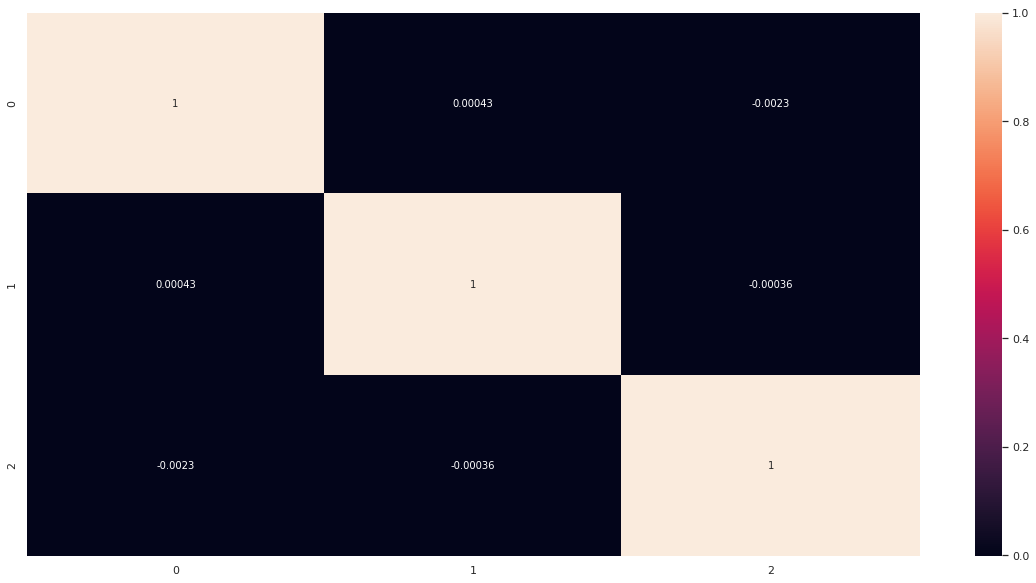

In [156]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [157]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.0004276153310071695 , min corr:  -0.0022536144922548147


#### Indeed - there is no correlation between any two components! Good job, PCA!
- We effectively have removed multicollinearity from our situation, and our models will be much more stable

In [158]:
pca_again = PCA(0.90)

In [159]:
df_train_pca2 = pca_again.fit_transform(rfm_df_scaled)
df_train_pca2.shape
# we see that PCA selected 2 components

(166, 2)

In [ ]:
grouped_df country

In [163]:
recommendation = pd.merge(grouped_df, country, on='country', how='inner')

In [165]:
recommendation.head()

,country,gdpp_x,mortality,life_expec_x,cluster_id,cluster_labels,child_mort,exports,health,imports,income,inflation,life_expec_y,total_fer,gdpp_y
0,Afghanistan,553,90.2,56.2,1,0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,4090,16.6,76.3,0,1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,4460,27.3,76.5,0,1,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,3530,119.0,60.1,1,0,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,12200,10.3,76.8,0,1,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [191]:
isOne = recommendation['cluster_labels'] == 0
print(isOne.head())

0     True
1    False
2    False
3     True
4    False
Name: cluster_labels, dtype: bool


In [192]:
print(isOne.shape)

(166,)


In [193]:
recom_isOne = recommendation[isOne]

In [194]:
print(recom_isOne.shape)

(26, 15)


In [195]:
#printing recommendations where HELP should invest their money . - see cluster label 0
print(recom_isOne.head())

         country  gdpp_x  mortality  life_expec_x  cluster_id  cluster_labels  \
0    Afghanistan     553       90.2          56.2           1               0   
3         Angola    3530      119.0          60.1           1               0   
17         Benin     758      111.0          61.8           1               0   
21      Botswana    6350       52.5          57.1           1               0   
25  Burkina Faso     575      116.0          57.9           1               0   

    child_mort  exports  health  imports  income  inflation  life_expec_y  \
0         90.2     10.0    7.58     44.9    1610      9.440          56.2   
3        119.0     62.3    2.85     42.9    5900     22.400          60.1   
17       111.0     23.8    4.10     37.2    1820      0.885          61.8   
21        52.5     43.6    8.30     51.3   13300      8.920          57.1   
25       116.0     19.2    6.74     29.6    1430      6.810          57.9   

    total_fer  gdpp_y  
0        5.82     553  
3 

In [196]:
recom_isOne.tail()

,country,gdpp_x,mortality,life_expec_x,cluster_id,cluster_labels,child_mort,exports,health,imports,income,inflation,life_expec_y,total_fer,gdpp_y
131,Sierra Leone,399,160.0,55.0,1,0,160.0,16.8,13.10,34.5,1220,17.20,55.0,5.20,399
136,South Africa,7280,53.7,54.3,1,0,53.7,28.6,8.94,27.4,12000,6.35,54.3,2.59,7280
149,Togo,488,90.3,58.7,1,0,90.3,40.2,7.65,57.3,1210,1.18,58.7,4.87,488
154,Uganda,595,81.0,56.8,1,0,81.0,17.1,9.01,28.6,1540,10.60,56.8,6.15,595
165,Zambia,1460,83.1,52.0,1,0,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


In [197]:
recom_isOne.head()

,country,gdpp_x,mortality,life_expec_x,cluster_id,cluster_labels,child_mort,exports,health,imports,income,inflation,life_expec_y,total_fer,gdpp_y
0,Afghanistan,553,90.2,56.2,1,0,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
3,Angola,3530,119.0,60.1,1,0,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
17,Benin,758,111.0,61.8,1,0,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758
21,Botswana,6350,52.5,57.1,1,0,52.5,43.6,8.30,51.3,13300,8.920,57.1,2.88,6350
25,Burkina Faso,575,116.0,57.9,1,0,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575


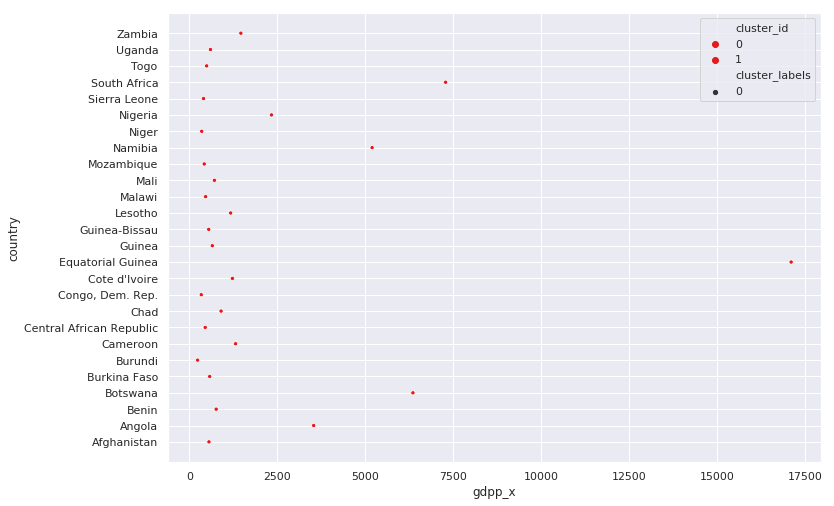

In [209]:
#where the money is most needed as per PCA
cmap = sns.cubehelix_palette(dark=3, light=.8, as_cmap=True)
sns.set(rc={'figure.figsize':(11.7, 8.27)})
ax2 = sns.scatterplot(x="gdpp_x", y="country",  hue="cluster_id", size="cluster_labels", palette = "Set1", data = recom_isOne, s=20)